# 1006개의 데이터로 Transfer_Learning 하기

- 논문의 모델에 1006개의 데이터를 넣고 학습을 시켜보자
- Augmentation을 하였을 때와 하지 않았을 때의 성능의 차이를 살펴보자

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
# 모델 관련 라이브러리
from tensorflow.keras.models import load_model
from tensorflow.keras             import utils, regularizers
from tensorflow.keras.models      import Sequential, load_model
from tensorflow.keras.layers      import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers  import Adam
from tensorflow.keras.constraints import MaxNorm

import os                       # I/O 관련된 작업에 필요한 패키지 
import numpy             as np  # 데이터 array 작업에 필요한 패키지
import tensorflow        as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt # 데이터 시각화에 관련된 작업에 필요한 패키지

#### 필요한 변수들 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# BATCH_SIZE 변수
BATCH_SIZE = 32

# 이미지 사이즈 변수
IMAGE_SIZE = [256, 256]

# EPOCH 크기 변수
EPOCHS = 150

#### GPU 사용여부 확인

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [4]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'cellpin/CellPin')
print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/mochafreddo/cellpin/CellPin
782
104
126


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'normal' in filename])
print('NORMAL images count in Train set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if 'cpe' in filename])
print('CPE images count in Train set :' + str(COUNT_CPE))

NORMAL images count in Train set :355
CPE images count in Train set :427


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in val_filenames if 'normal' in filename])
print('NORMAL images count in Validation set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if 'cpe' in filename])
print('CPE images count in Validation set :' + str(COUNT_CPE))

NORMAL images count in Validation set :50
CPE images count in Validation set :76


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in test_filenames if 'normal' in filename])
print('NORMAL images count in Test set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if 'cpe' in filename])
print('CPE images count in Test set :' + str(COUNT_CPE))

NORMAL images count in Test set :40
CPE images count in Test set :64


#### tf.data 인스턴스를 만들기

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
train_list_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [10]:
len(train_list_ds)

782

#### train data와 val data의 개수 확인

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print('Train images count :' + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('Validation images count :' + str(VAL_IMG_COUNT))

Train images count :782
Validation images count :126


#### 라벨 이름들 확인

In [12]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['normal' 'cpe']


#### 라벨링 함수를 만들어 보기

In [13]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'cpe'

In [14]:
train_list_ds.map(get_label, num_parallel_calls=AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


<ParallelMapDataset shapes: (), types: tf.bool>

In [15]:
train_list_ds

<TensorSliceDataset shapes: (), types: tf.string>

#### decode_img 함수와 process_path 함수를 만들기

In [16]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 1)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### train과 val에 함수들 적용해주기

In [17]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#### 전처리 함수 만들기 및 적용

In [18]:
def augment(image,label):
    image = tf.image.flip_left_right(image)  # 좌우 반전
    image = tf.image.flip_up_down(image)  # 상하 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size = 1000, with_aug = False):
    
    if  with_aug:
        ds = ds.map(
            augment,  # augment 함수 적용
            num_parallel_calls = 2
            )    

    ds = ds.shuffle(buffer_size = shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds

In [19]:
train_ds_no_aug = prepare_for_training(train_ds, with_aug = False)
val_ds_no_aug = prepare_for_training(val_ds, with_aug = False)


train_ds_aug = prepare_for_training(train_ds, with_aug = True)
val_ds_aug = prepare_for_training(val_ds, with_aug = True)

#### Image shape를 변경 체크하기

In [20]:
for image, label in train_ds_no_aug.take(1):
    print('Image shape :', image.numpy().shape)
    print('Label :', label.numpy().shape)

Image shape : (32, 256, 256, 1)
Label : (32,)


In [21]:
# for image, label in train_ds_aug.take(1):
#     print('Image shape :', image.numpy().shape)
#     print('Label :', label.numpy().shape)

#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [22]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

104


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

In [23]:
# image_batch, label_batch = next(iter(train_ds_no_aug))

# def show_batch(image_batch, label_batch):
#     plt.figure(figsize = (10, 10))
#     for n in range(16):
#         ax = plt.subplot(4, 4, n + 1)
#         plt.imshow(image_batch[n], cmap = 'gray')
#         if label_batch[n]:
#             plt.title('CPE')
#         else:
#             plt.title('NORMAL')
#         plt.axis('off')

# show_batch(image_batch.numpy(), label_batch.numpy())

In [36]:
image_batch, label_batch = next(iter(train_ds_aug))

label_batch

<tf.Tensor: shape=(32,), dtype=bool, numpy=
array([ True,  True,  True,  True, False, False,  True, False, False,
       False, False,  True, False,  True, False, False,  True, False,
        True,  True, False, False, False, False,  True, False,  True,
        True,  True,  True, False,  True])>

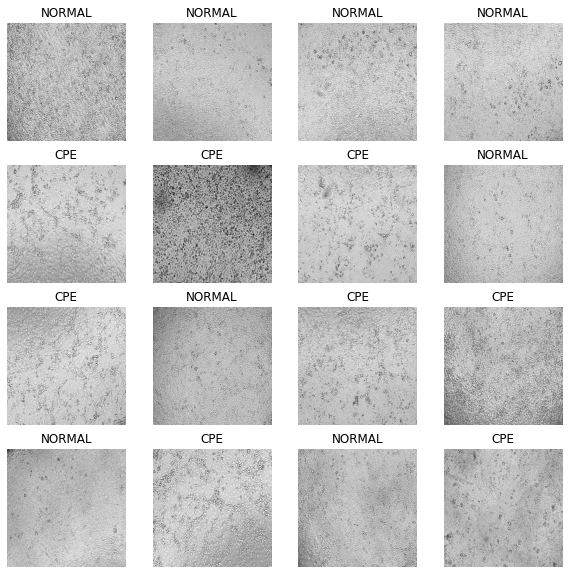

In [24]:
image_batch, label_batch = next(iter(train_ds_aug))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n], cmap = 'gray')
        if label_batch[n]:
            plt.title('CPE')
        else:
            plt.title('NORMAL')
        plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())

In [25]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

no_aug_model = build_model()
with_aug_model = build_model()

In [26]:
no_aug_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 16, 16, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)      

In [27]:
with_aug_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 64, 64, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 32, 32, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 16, 16, 128)       27072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 128)     

## Step 5. 모델 훈련

#### GPU사용하여 model complie

In [28]:
with tf.device('/GPU:0'):

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    no_aug_model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )
     
    no_aug_check_point = tf.keras.callbacks.ModelCheckpoint('test_paper_model_no_aug.h5')

In [29]:
with tf.device('/GPU:0'):

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    with_aug_model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )
    

    with_aug_check_point = tf.keras.callbacks.ModelCheckpoint('test_paper_model_with_aug.h5')

#### 모델 fitting

In [30]:
with tf.device('/GPU:0'):
    history_no_aug_model = no_aug_model.fit(
        train_ds_no_aug,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds_no_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks = [no_aug_check_point]
    )

Epoch 1/150
24/24 [==============================] - 17s 344ms/step - loss: 0.8823 - accuracy: 0.4987 - precision: 0.5482 - recall: 0.4998 - val_loss: 0.6843 - val_accuracy: 0.6042 - val_precision: 0.6042 - val_recall: 1.0000
Epoch 2/150
24/24 [==============================] - 8s 324ms/step - loss: 0.8261 - accuracy: 0.4893 - precision: 0.5416 - recall: 0.4631 - val_loss: 0.6883 - val_accuracy: 0.6146 - val_precision: 0.6146 - val_recall: 1.0000
Epoch 3/150
24/24 [==============================] - 7s 310ms/step - loss: 0.7778 - accuracy: 0.5279 - precision: 0.5542 - recall: 0.5505 - val_loss: 0.6905 - val_accuracy: 0.5729 - val_precision: 0.5729 - val_recall: 1.0000
Epoch 4/150
24/24 [==============================] - 7s 313ms/step - loss: 0.7066 - accuracy: 0.6233 - precision: 0.6834 - recall: 0.5817 - val_loss: 0.6919 - val_accuracy: 0.6146 - val_precision: 0.6146 - val_recall: 1.0000
Epoch 5/150
24/24 [==============================] - 7s 308ms/step - loss: 0.5414 - accuracy: 0.716

24/24 [==============================] - 7s 313ms/step - loss: 0.0599 - accuracy: 0.9771 - precision: 0.9681 - recall: 0.9892 - val_loss: 10.9507 - val_accuracy: 0.4062 - val_precision: 1.0000 - val_recall: 0.0172
Epoch 37/150
24/24 [==============================] - 7s 310ms/step - loss: 0.0628 - accuracy: 0.9750 - precision: 0.9702 - recall: 0.9838 - val_loss: 4.0012 - val_accuracy: 0.5000 - val_precision: 1.0000 - val_recall: 0.1724
Epoch 38/150
24/24 [==============================] - 7s 307ms/step - loss: 0.1036 - accuracy: 0.9659 - precision: 0.9683 - recall: 0.9690 - val_loss: 4.3461 - val_accuracy: 0.5104 - val_precision: 1.0000 - val_recall: 0.1897
Epoch 39/150
24/24 [==============================] - 7s 307ms/step - loss: 0.0729 - accuracy: 0.9753 - precision: 0.9662 - recall: 0.9882 - val_loss: 0.3382 - val_accuracy: 0.9271 - val_precision: 1.0000 - val_recall: 0.8793
Epoch 40/150
24/24 [==============================] - 7s 309ms/step - loss: 0.0307 - accuracy: 0.9895 - prec

24/24 [==============================] - 7s 309ms/step - loss: 0.0316 - accuracy: 0.9899 - precision: 0.9966 - recall: 0.9859 - val_loss: 1.7427 - val_accuracy: 0.7083 - val_precision: 1.0000 - val_recall: 0.5625
Epoch 73/150
24/24 [==============================] - 7s 309ms/step - loss: 0.0269 - accuracy: 0.9927 - precision: 0.9944 - recall: 0.9923 - val_loss: 2.5317 - val_accuracy: 0.6458 - val_precision: 1.0000 - val_recall: 0.4138
Epoch 74/150
24/24 [==============================] - 7s 311ms/step - loss: 0.0242 - accuracy: 0.9904 - precision: 0.9990 - recall: 0.9841 - val_loss: 9.0983 - val_accuracy: 0.4583 - val_precision: 1.0000 - val_recall: 0.0877
Epoch 75/150
24/24 [==============================] - 7s 315ms/step - loss: 0.0787 - accuracy: 0.9776 - precision: 0.9674 - recall: 0.9887 - val_loss: 0.9873 - val_accuracy: 0.8021 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 76/150
24/24 [==============================] - 7s 313ms/step - loss: 0.0511 - accuracy: 0.9898 - preci

24/24 [==============================] - 7s 312ms/step - loss: 0.0155 - accuracy: 0.9967 - precision: 0.9947 - recall: 0.9993 - val_loss: 1.7962 - val_accuracy: 0.7396 - val_precision: 1.0000 - val_recall: 0.5614
Epoch 109/150
24/24 [==============================] - 7s 313ms/step - loss: 0.0436 - accuracy: 0.9848 - precision: 0.9877 - recall: 0.9846 - val_loss: 2.1369 - val_accuracy: 0.6458 - val_precision: 0.6304 - val_recall: 1.0000
Epoch 110/150
24/24 [==============================] - 7s 312ms/step - loss: 0.0246 - accuracy: 0.9903 - precision: 0.9893 - recall: 0.9932 - val_loss: 1.6695 - val_accuracy: 0.6771 - val_precision: 0.6395 - val_recall: 1.0000
Epoch 111/150
24/24 [==============================] - 7s 311ms/step - loss: 0.0974 - accuracy: 0.9727 - precision: 0.9706 - recall: 0.9779 - val_loss: 17.8043 - val_accuracy: 0.4167 - val_precision: 1.0000 - val_recall: 0.0175
Epoch 112/150
24/24 [==============================] - 7s 314ms/step - loss: 0.0311 - accuracy: 0.9871 - 

24/24 [==============================] - 7s 319ms/step - loss: 0.0203 - accuracy: 0.9957 - precision: 0.9963 - recall: 0.9955 - val_loss: 0.9728 - val_accuracy: 0.8229 - val_precision: 1.0000 - val_recall: 0.7119
Epoch 145/150
24/24 [==============================] - 7s 313ms/step - loss: 0.0375 - accuracy: 0.9912 - precision: 0.9883 - recall: 0.9950 - val_loss: 1.4782 - val_accuracy: 0.6979 - val_precision: 0.6548 - val_recall: 1.0000
Epoch 146/150
24/24 [==============================] - 7s 313ms/step - loss: 0.0129 - accuracy: 0.9958 - precision: 0.9988 - recall: 0.9935 - val_loss: 1.5305 - val_accuracy: 0.7292 - val_precision: 1.0000 - val_recall: 0.5185
Epoch 147/150
24/24 [==============================] - 7s 313ms/step - loss: 0.0192 - accuracy: 0.9936 - precision: 0.9883 - recall: 1.0000 - val_loss: 3.2789 - val_accuracy: 0.6146 - val_precision: 0.6146 - val_recall: 1.0000
Epoch 148/150
24/24 [==============================] - 7s 313ms/step - loss: 0.0231 - accuracy: 0.9903 - p

In [31]:
with tf.device('/GPU:0'):
    history_with_aug_model = with_aug_model.fit(
        train_ds_aug,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks = [with_aug_check_point]
    )

Epoch 1/150
24/24 [==============================] - 15s 333ms/step - loss: 0.8637 - accuracy: 0.5686 - precision: 0.6163 - recall: 0.5716 - val_loss: 0.6830 - val_accuracy: 0.5729 - val_precision: 0.5729 - val_recall: 1.0000
Epoch 2/150
24/24 [==============================] - 8s 326ms/step - loss: 0.6488 - accuracy: 0.6828 - precision: 0.7093 - recall: 0.7115 - val_loss: 0.6818 - val_accuracy: 0.6042 - val_precision: 0.6042 - val_recall: 1.0000
Epoch 3/150
24/24 [==============================] - 7s 314ms/step - loss: 0.4806 - accuracy: 0.7845 - precision: 0.8088 - recall: 0.7946 - val_loss: 0.7434 - val_accuracy: 0.5833 - val_precision: 0.5833 - val_recall: 1.0000
Epoch 4/150
24/24 [==============================] - 7s 309ms/step - loss: 0.3903 - accuracy: 0.8192 - precision: 0.8452 - recall: 0.8157 - val_loss: 0.6893 - val_accuracy: 0.6562 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 5/150
24/24 [==============================] - 7s 313ms/step - loss: 0.3621 - accuracy: 0.856

24/24 [==============================] - 7s 298ms/step - loss: 0.0401 - accuracy: 0.9894 - precision: 0.9876 - recall: 0.9929 - val_loss: 1.9543 - val_accuracy: 0.6771 - val_precision: 1.0000 - val_recall: 0.4364
Epoch 37/150
24/24 [==============================] - 7s 302ms/step - loss: 0.0629 - accuracy: 0.9815 - precision: 0.9813 - recall: 0.9829 - val_loss: 0.2709 - val_accuracy: 0.9062 - val_precision: 0.8966 - val_recall: 0.9455
Epoch 38/150
24/24 [==============================] - 7s 314ms/step - loss: 0.0543 - accuracy: 0.9753 - precision: 0.9826 - recall: 0.9729 - val_loss: 1.5389 - val_accuracy: 0.7292 - val_precision: 1.0000 - val_recall: 0.5357
Epoch 39/150
24/24 [==============================] - 7s 310ms/step - loss: 0.0252 - accuracy: 0.9918 - precision: 0.9858 - recall: 0.9989 - val_loss: 0.3392 - val_accuracy: 0.8750 - val_precision: 0.9245 - val_recall: 0.8596
Epoch 40/150
24/24 [==============================] - 7s 312ms/step - loss: 0.0312 - accuracy: 0.9890 - preci

24/24 [==============================] - 7s 312ms/step - loss: 0.0640 - accuracy: 0.9814 - precision: 0.9978 - recall: 0.9706 - val_loss: 6.0642 - val_accuracy: 0.5625 - val_precision: 1.0000 - val_recall: 0.2222
Epoch 73/150
24/24 [==============================] - 7s 308ms/step - loss: 0.0754 - accuracy: 0.9736 - precision: 0.9559 - recall: 0.9953 - val_loss: 0.7547 - val_accuracy: 0.7396 - val_precision: 0.6988 - val_recall: 1.0000
Epoch 74/150
24/24 [==============================] - 7s 311ms/step - loss: 0.0181 - accuracy: 0.9945 - precision: 1.0000 - recall: 0.9902 - val_loss: 0.2391 - val_accuracy: 0.9167 - val_precision: 0.8906 - val_recall: 0.9828
Epoch 75/150
24/24 [==============================] - 7s 313ms/step - loss: 0.0352 - accuracy: 0.9889 - precision: 0.9880 - recall: 0.9908 - val_loss: 1.2707 - val_accuracy: 0.7083 - val_precision: 0.6706 - val_recall: 1.0000
Epoch 76/150
24/24 [==============================] - 7s 310ms/step - loss: 0.0313 - accuracy: 0.9908 - preci

24/24 [==============================] - 7s 310ms/step - loss: 0.0309 - accuracy: 0.9911 - precision: 0.9897 - recall: 0.9940 - val_loss: 2.3196 - val_accuracy: 0.6667 - val_precision: 1.0000 - val_recall: 0.4483
Epoch 109/150
24/24 [==============================] - 7s 312ms/step - loss: 0.0279 - accuracy: 0.9852 - precision: 0.9739 - recall: 0.9988 - val_loss: 0.2997 - val_accuracy: 0.9062 - val_precision: 0.9800 - val_recall: 0.8596
Epoch 110/150
24/24 [==============================] - 7s 311ms/step - loss: 0.0770 - accuracy: 0.9800 - precision: 0.9736 - recall: 0.9876 - val_loss: 0.3309 - val_accuracy: 0.9167 - val_precision: 0.9483 - val_recall: 0.9167
Epoch 111/150
24/24 [==============================] - 7s 313ms/step - loss: 0.0178 - accuracy: 0.9953 - precision: 0.9965 - recall: 0.9950 - val_loss: 1.4889 - val_accuracy: 0.7500 - val_precision: 0.9722 - val_recall: 0.6034
Epoch 112/150
24/24 [==============================] - 7s 310ms/step - loss: 0.0490 - accuracy: 0.9830 - p

24/24 [==============================] - 7s 310ms/step - loss: 0.0060 - accuracy: 0.9981 - precision: 0.9964 - recall: 1.0000 - val_loss: 0.5321 - val_accuracy: 0.9062 - val_precision: 1.0000 - val_recall: 0.8421
Epoch 145/150
24/24 [==============================] - 7s 307ms/step - loss: 0.0160 - accuracy: 0.9963 - precision: 0.9983 - recall: 0.9949 - val_loss: 2.3169 - val_accuracy: 0.6562 - val_precision: 1.0000 - val_recall: 0.4310
Epoch 146/150
24/24 [==============================] - 7s 298ms/step - loss: 0.0289 - accuracy: 0.9924 - precision: 0.9860 - recall: 1.0000 - val_loss: 0.3100 - val_accuracy: 0.9271 - val_precision: 0.9474 - val_recall: 0.9310
Epoch 147/150
24/24 [==============================] - 7s 299ms/step - loss: 0.0236 - accuracy: 0.9902 - precision: 0.9997 - recall: 0.9828 - val_loss: 2.0990 - val_accuracy: 0.7188 - val_precision: 1.0000 - val_recall: 0.5345
Epoch 148/150
24/24 [==============================] - 7s 300ms/step - loss: 0.0532 - accuracy: 0.9820 - p

## Step 6. 결과 확인 및 시각화

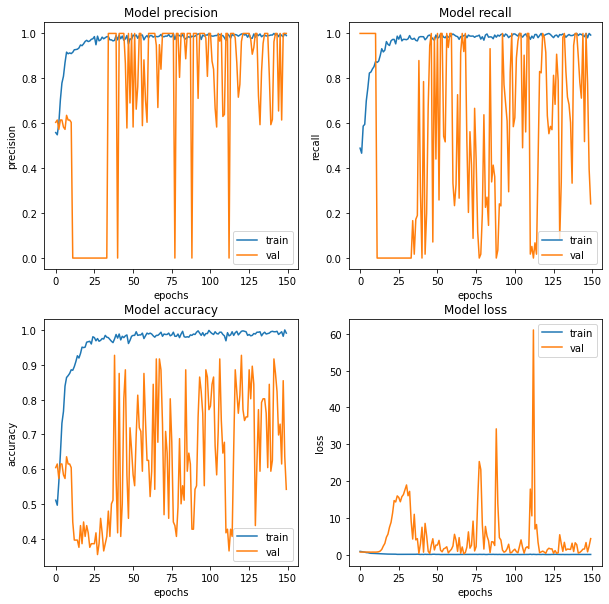

In [32]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_aug_model.history[met])
    ax[i].plot(history_no_aug_model.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

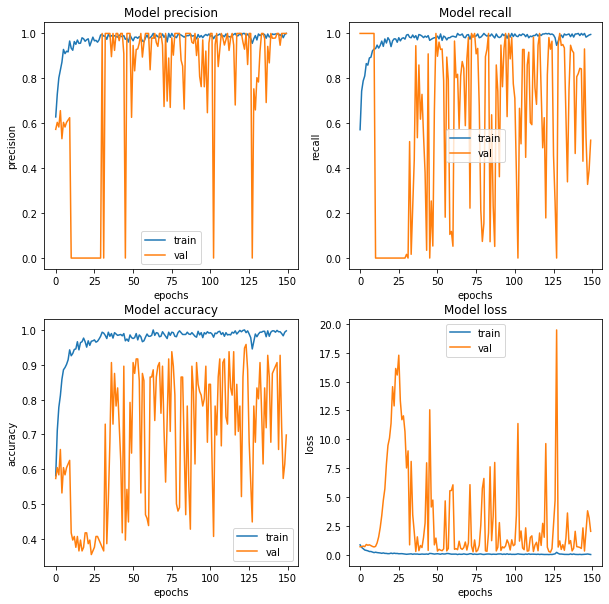

In [33]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_with_aug_model.history[met])
    ax[i].plot(history_with_aug_model.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Step 7. 최종 Test dataset 검정하기

In [34]:
no_aug_model = tf.keras.models.load_model('test_paper_model_no_aug.h5')
loss, acc, prec, rec = no_aug_model.evaluate(test_ds)

4/4 [==============================] - 1s 71ms/step - loss: 3.8179 - accuracy: 0.6346 - precision: 1.0000 - recall: 0.4062


In [35]:
with_aug_model = tf.keras.models.load_model('test_paper_model_with_aug.h5')
loss, acc, prec, rec = with_aug_model.evaluate(test_ds)

4/4 [==============================] - 1s 57ms/step - loss: 1.2626 - accuracy: 0.7981 - precision: 1.0000 - recall: 0.6719


In [40]:
with_aug_model.predict(test_ds.take(3))

array([[9.8254955e-01],
       [3.2836884e-01],
       [7.3262363e-06],
       [9.9836010e-01],
       [6.5984474e-05],
       [9.9872428e-01],
       [9.9957973e-01],
       [1.1480520e-05],
       [9.7992609e-04],
       [3.4357898e-03],
       [9.9938536e-01],
       [1.3326086e-06],
       [9.9959284e-01],
       [5.9064373e-04],
       [1.0414227e-05],
       [7.1789613e-03],
       [9.9684119e-01],
       [7.3768473e-01],
       [2.4279286e-06],
       [3.9579817e-07],
       [2.4575911e-06],
       [1.9329667e-02],
       [9.9966848e-01],
       [4.3450082e-06],
       [5.8587170e-07],
       [5.2519532e-05],
       [8.7901723e-01],
       [8.3480845e-06],
       [9.1366804e-01],
       [9.9981815e-01],
       [9.9921870e-01],
       [9.9885011e-01],
       [9.9951410e-01],
       [9.9896073e-01],
       [1.5667800e-03],
       [1.1633592e-02],
       [7.4922364e-06],
       [9.9962664e-01],
       [1.4695531e-01],
       [9.9735343e-01],
       [8.1736966e-05],
       [9.998799

## Discussion